In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy

# Adding library directory to python search path
import os
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

In [62]:
data = mipt.read_excel('data/data.xlsx', usecols=(0, 1, 2, 3, 4, 5, 6 ,7 ,8, 9, 10, 11, 12, 13, 14, 15), header=(0,1))
#data['Ra']
data

Ra                                    Th_Am                     \
            elem channel resolution    square        elem channel resolution   
0  Ra^{226}_{88}    1640  24.331704  2.203331  Th^{x}_{x}  1622.0    15.7952   
1  Po^{210}_{84}    1815  22.576647  0.472037  Th^{x}_{x}  1894.0    17.1208   
2  Rn^{222}_{86}    1881  23.968700  2.536300         NaN     NaN        NaN   
3  Po^{218}_{84}    2055  21.054200  2.040600         NaN     NaN        NaN   
4  Po^{214}_{84}    2617  22.499200  2.033200         NaN     NaN        NaN   

                      Pu                                        U          \
   square           elem channel resolution  square          elem channel   
0  2.1286     Pu^{x}_{x}  1788.0    16.8127  6.2065  U^{238}_{92}  1400.0   
1  2.5141  Pu^{238}_{94}  1894.0    20.8960  0.1610  U^{234}_{92}  1629.0   
2     NaN            NaN     NaN        NaN     NaN           NaN     NaN   
3     NaN            NaN     NaN        NaN     NaN           NaN     NaN   
4     NaN            NaN     NaN        NaN     NaN           NaN     NaN   

                      
  resolution  square  
0    87.9598  0.9578  
1    43.1976  1.0393  
2        NaN     NaN  
3        NaN     NaN  
4        NaN     NaN

In [4]:
Ra = mipt.read_excel('data/ra.xlsx', usecols=(0,1), header=(0))
Ra

,Channel,Counts
0,1.0,0.0
1,2.0,0.0
2,3.0,0.0
3,4.0,0.0
4,5.0,0.0
...,...,...
4091,4092.0,0.0
4092,4093.0,0.0
4093,4094.0,0.0
4094,4095.0,0.0


$$ a = (2.97 \pm 0.01) \cdot 10^{-3} \; \frac{ \text{МэВ} }{ \text{кан.} }$$
$$ b = (-0.10 \pm 0.02) \; \text{МэВ}$$


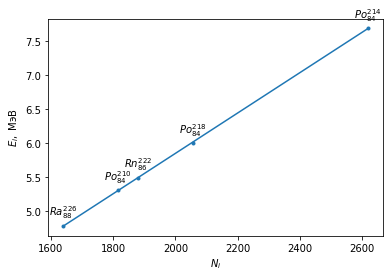

In [133]:
data = mipt.read_excel('data/data.xlsx', usecols=(0, 1, 2, 3, 4, 5, 6 ,7 ,8, 9, 10, 11, 12, 13, 14, 15), header=(0,1))

energy = np.array([4.784, 5.304, 5.490, 6.002, 7.687])
channels = data['Ra']['channel'].dropna()
elems = data['Ra']['elem']


X, Y, equ = mipt.plot(channels, energy)


for i in range(X.size):
    label = "${}$".format(elems[i])

    plt.annotate(label, # this is the text
                 (X[i], Y[i]), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 zorder=-1) # horizontal alignment can be left, right or center


energy_coeff = mipt.mnk(X, Y).data['a'][0]
energy_coeff_err = mipt.mnk(X, Y).data['da'][0]

#print('\$\\alpha = {:.2f} \\pm {:.2f} \\frac\{\\text\{МэВ\}\}\{кан.\}\$'.format(energy_coeff, energy_coeff_err))


mnk_tab = mipt.mnk(X, Y).data

A = mnk_tab['a'][0]
B = mnk_tab['b'][0]
dA = mnk_tab['da'][0]
dB = mnk_tab['db'][0]

print('$$ a = ({:.2f} \\pm {:.2f}) \\cdot 10^{{-3}} \\; \\frac{{ \\text{{МэВ}} }}{{ \\text{{кан.}} }}$$'
      .format(A * 1000, dA * 1000))

print('$$ b = ({:.2f} \\pm {:.2f}) \\; \\text{{МэВ}}$$'
      .format(B, dB))

#(energy_coeff * 2055 - 6.002) / 6.002


def calc_energy(x, dx):
    return A*x + B, np.linalg.norm([x*dA, dB, A*dx])

mnk_tab

#mnk_tab.to_latex('gen/')

plt.xlabel(r"$N_i$")
plt.ylabel(r"$E_i,$ МэВ")

# plt.legend()
plt.savefig('gen/fig-w-channel.pdf')

In [127]:


def process_data_for_single_elem(file, name, export_name, fr, to):
    El = mipt.read_excel(file, usecols=(0,1), header=(0))
    
    x = El['Channel'][fr:to]
    y = El['Counts'][fr:to]
    
    elems = data[name]['elem'].dropna()
    x_pikes = data[name]['channel'].dropna()
    print(elems)
    y_pikes = np.array(list(y[x_pikes])) # Awesome!!!

    resolution = data[name]['resolution'].dropna()
    energy_resolution = resolution * A
    energy_resolution_err = energy_resolution * dA / A

    arr_energy = []
    arr_energy_err = []
    arr_denergy_err = []

    for i in range(x_pikes.size):

        energ, energ_err = calc_energy(x_pikes[i], 0)
        label = "${}$\n${:.2f} \\pm {:.2f}$ МэВ".format(elems[i], energ, energ_err)
        arr_energy.append(energ)
        arr_energy_err.append(energ_err)
        arr_denergy_err.append(dA * resolution[i])
        plt.annotate(label, # this is the text
                     (x_pikes[i], y_pikes[i]), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

        plt.axvline(x = x_pikes[i], color = 'purple', zorder=14, lw=1, ls='-.')


    plt.errorbar(x_pikes, y_pikes, color='purple', zorder=16, xerr = 0, fmt='o', ms=0.2)
    plt.plot(x, y)

    arr_energy = np.array(arr_energy)
    arr_energy_err = np.array(arr_energy_err)
    arr_denergy_err = np.array(arr_denergy_err)
    arr_denergy = np.array(resolution * A)
    R = arr_denergy / arr_energy
    dR = R * np.sqrt((arr_denergy_err/arr_denergy)**2 + (arr_energy_err/arr_energy)**2)
    R_f = 1 / np.sqrt(arr_energy / 3.6e-6)
    arr_epsilon = arr_energy_err / arr_energy
    
    energy_df = pd.DataFrame(arr_energy, columns = ['E_i']) 
    energy_err_df = pd.DataFrame(arr_energy_err, columns = ['E_i_err'])
    denergy_df = pd.DataFrame(arr_denergy, columns = ['dE_i'])
    denergy_err_df = pd.DataFrame(arr_denergy_err, columns = ['dE_i_err'])
    R_df = pd.DataFrame(R, columns = ['R_i'])
    R_f_df = pd.DataFrame(R_f, columns = ['R_{f,i}'])
    epsilon_df = pd.DataFrame(arr_epsilon, columns = ['epsilon'])
    #R_err_df = pd.DataFrame(dR, columns = ['R_i_err'])

    
    
    export = pd.concat([
        x_pikes.rename('N_i'),
        resolution.rename('dN_i'),
        energy_df,
        epsilon_df,
        #energy_err_df,
        denergy_df,
        #denergy_err_df,
        R_df,
        R_f_df,
    ], axis=1)

    fmt = {
        'N_i' : [r'$N_i$', '{:.0f}', 0],
        'dN_i' : [r'$\Delta N_i$', '{:.2f}', 0],
        'E_i' : [r'$E_i$, МэВ', '{:.2f}', 0],
        'E_i_err' : [r'$\sigma_{E_i}$, МэВ', '{:.2f}', 0],
        'dE_i' : [r'$\Delta E_i$, МэВ', '{:.4f}', 0],
        'dE_i_err' : [r'$\sigma_{\Delta E_i}$, МэВ', '{:.4f}', 0],
        'R_i' : [r'$R_i \cdot 10^2$', '{:.2f}', 2],
        'R_i_err' : [r'$\sigma_{R_i}$', '{:.3f}', 0],
        'R_{f,i}' : [r'$R_{f,i} \cdot 10^2$', '{:.3f}', 2],
        'epsilon' : [r'$\varepsilon_{E_i}, \%$', '{:.1f}', 2],
    }

    tab = mipt.table(export, fmt)
    tab.to_latex('gen/tab-{}.tex'.format(export_name))
    tab.rename().data

    plt.xlabel(r"N")
    plt.ylabel(r"Particles")

    plt.savefig('gen/fig-{}.pdf'.format(export_name))

    return tab.rename().data    

0    Ra^{226}_{88}
1    Po^{210}_{84}
2    Rn^{222}_{86}
3    Po^{218}_{84}
4    Po^{214}_{84}
Name: elem, dtype: object


,$N_i$,$\Delta N_i$,"$E_i$, МэВ","$\varepsilon_{E_i}, \%$","$\Delta E_i$, МэВ",$R_i \cdot 10^2$,"$R_{f,i} \cdot 10^2$"
0,1640,24.331704,4.778701,0.005992,0.072315,0.015133,0.000868
1,1815,22.576647,5.298812,0.005639,0.067099,0.012663,0.000824
2,1881,23.968700,5.494969,0.005526,0.071237,0.012964,0.000809
3,2055,21.054200,6.012108,0.005272,0.062574,0.010408,0.000774
4,2617,22.499200,7.682410,0.004731,0.066869,0.008704,0.000685


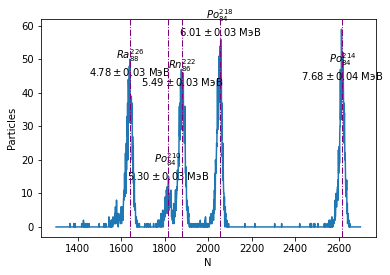

In [128]:
tab = process_data_for_single_elem(
    file = 'data/ra.xlsx',
    name = 'Ra',
    fr = 1300,
    to = 2700,
    export_name = 'ra'
)

tab

0    Th^{x}_{x}
1    Th^{x}_{x}
Name: elem, dtype: object


,$N_i$,$\Delta N_i$,"$E_i$, МэВ","$\varepsilon_{E_i}, \%$","$\Delta E_i$, МэВ",$R_i \cdot 10^2$,"$R_{f,i} \cdot 10^2$"
0,1622.0,15.7952,4.725203,0.006034,0.046944,0.009935,0.000873
1,1894.0,17.1208,5.533606,0.005505,0.050884,0.009195,0.000807


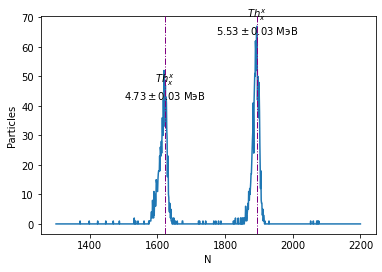

In [129]:
tab = process_data_for_single_elem(
    file = 'data/th_am.xlsx',
    name = 'Th_Am',
    fr = 1300,
    to = 2200,
    export_name = 'th_am'
)

tab

0       Pu^{x}_{x}
1    Pu^{238}_{94}
Name: elem, dtype: object


,$N_i$,$\Delta N_i$,"$E_i$, МэВ","$\varepsilon_{E_i}, \%$","$\Delta E_i$, МэВ",$R_i \cdot 10^2$,"$R_{f,i} \cdot 10^2$"
0,1788.0,16.8127,5.218567,0.005688,0.049968,0.009575,0.000831
1,1894.0,20.8960,5.533606,0.005505,0.062104,0.011223,0.000807


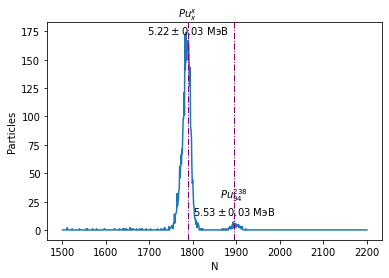

In [130]:
tab = process_data_for_single_elem(
    file = 'data/pu.xlsx',
    name = 'Pu',
    fr = 1500,
    to = 2200,
    export_name = 'pu'
)

tab

0    U^{238}_{92}
1    U^{234}_{92}
Name: elem, dtype: object


,$N_i$,$\Delta N_i$,"$E_i$, МэВ","$\varepsilon_{E_i}, \%$","$\Delta E_i$, МэВ",$R_i \cdot 10^2$,"$R_{f,i} \cdot 10^2$"
0,1400.0,87.9598,4.065405,0.006655,0.261422,0.064304,0.000941
1,1629.0,43.1976,4.746008,0.006017,0.128386,0.027051,0.000871


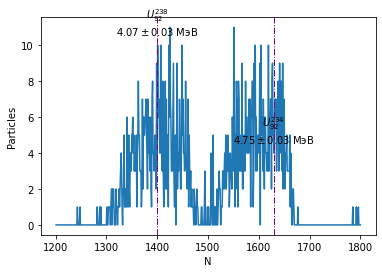

In [131]:
tab = process_data_for_single_elem(
    file = 'data/u.xlsx',
    name = 'U',
    fr = 1200,
    to = 1800,
    export_name = 'u'
)

tab

,$N_i$,$dN_i$,"$E_i$, МэВ","$\sigma_{E_i}$, МэВ","$\Delta E_i$, МэВ","$\sigma_{\Delta E_i}$, МэВ"
0,1640,24.331704,4.778701,0.028634,0.072315,0.000267
1,1815,22.576647,5.298812,0.029879,0.067099,0.000248
2,1881,23.968700,5.494969,0.030366,0.071237,0.000263
3,2055,21.054200,6.012108,0.031695,0.062574,0.000231
4,2617,22.499200,7.682410,0.036343,0.066869,0.000247


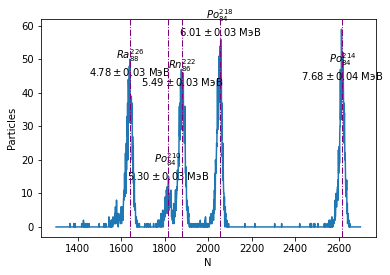

In [125]:
name = 'Ra'
tabfile = 'ra'
file = 'data/ra.xlsx'
fr = 1300
to = 2700

x = Ra['Channel'][fr:to]
y = Ra['Counts'][fr:to]

elem_data = mipt.read_excel(file, usecols=(0,1), header=(0))
elems = data[name]['elem']
x_pikes = data[name]['channel'].dropna()
y_pikes = np.array(list(y[x_pikes])) # Awesome!!!

resolution = data['Ra']['resolution']
energy_resolution = resolution * A
energy_resolution_err = energy_resolution * dA / A

arr_energy = []
arr_energy_err = []
arr_denergy_err = []

for i in range(x_pikes.size):
    
    energ, energ_err = calc_energy(x_pikes[i], 0)
    label = "${}$\n${:.2f} \\pm {:.2f}$ МэВ".format(elems[i], energ, energ_err)
    arr_energy.append(energ)
    arr_energy_err.append(energ_err)
    arr_denergy_err.append(dA * resolution[i])
    plt.annotate(label, # this is the text
                 (x_pikes[i], y_pikes[i]), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
    plt.axvline(x = x_pikes[i], color = 'purple', zorder=14, lw=1, ls='-.')


plt.errorbar(x_pikes, y_pikes, color='purple', zorder=16, xerr = 0, fmt='o', ms=0.2)
plt.plot(x, y)

arr_energy = np.array(arr_energy)
arr_energy_err = np.array(arr_energy_err)
arr_denergy_err = np.array(arr_denergy_err)
arr_denergy = np.array(resolution * A)

energy_df = pd.DataFrame(arr_energy, columns = ['E_i']) 
energy_err_df = pd.DataFrame(arr_energy_err, columns = ['E_i_err'])
denergy_df = pd.DataFrame(arr_denergy, columns = ['dE_i'])
denergy_err_df = pd.DataFrame(arr_denergy_err, columns = ['dE_i_err'])



export = pd.concat([
    x_pikes.rename('N_i'),
    resolution.rename('dN_i'),
    energy_df,
    energy_err_df,
    denergy_df,
    denergy_err_df,
], axis=1)

fmt = {
    'N_i' : [r'$N_i$', '{:.1f}', 0],
    'dN_i' : [r'$dN_i$', '{:.2f}', 0],
    'E_i' : [r'$E_i$, МэВ', '{:.2f}', 0],
    'E_i_err' : [r'$\sigma_{E_i}$, МэВ', '{:.2f}', 0],
    'dE_i' : [r'$\Delta E_i$, МэВ', '{:.4f}', 0],
    'dE_i_err' : [r'$\sigma_{\Delta E_i}$, МэВ', '{:.4f}', 0],
}

tab = mipt.table(export, fmt)
tab.to_latex('gen/tab-{}.tex'.format(tabfile))
tab.rename().data


plt.xlabel(r"N")
plt.ylabel(r"Particles")

plt.savefig('gen/fig-{}.pdf'.format(tabfile))

tab.rename().data

# Проверка

$$ \rho = \frac{ \cov_{ xy } }{ \sigma_x \cdot \sigma_y} = 0.9964 $$


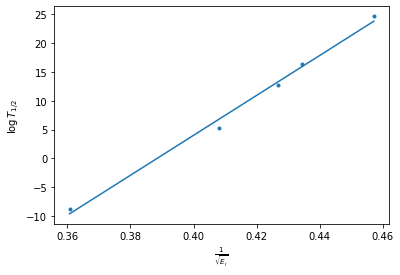

In [155]:
te_data = mipt.read_excel('data/te.xlsx', usecols=(0,1), header=(0))

y = np.log(te_data['T'])
x = 1/np.sqrt(te_data['E'])

mipt.plot(x, y)

plt.xlabel(r"$\frac{1}{\sqrt{E_i}}$")
plt.ylabel(r"$\log{T_{1/2}}$")

plt.savefig('gen/fig-te.pdf')

mnk = mipt.mnk(x, y)
mnkd = mnk.data

r = mnkd['rxy'] / (mnkd['sx'] * mnkd['sy'])**0.5


print('$$ \\rho = \\frac{{ \\cov_{{ xy }} }}{{ \\sigma_x \\cdot \\sigma_y}} = {:.4f} $$'.format(r[0]))

In [86]:
y_pikes = np.array(list(y[x_pikes]))
y_pikes


array([42., 11., 39., 54., 41.])

In [87]:
y_pikes = data['Ra']['channel'].dropna()
y_pikes[0]

1640

## Опробование работы

In [225]:
data = mipt.read_excel('data/5.8.1-raw.xlsx', usecols=(0,1), header=(0)).dropna()
data

termo_coeff = (47000-29000)/(1168-716)

t_out = 22
t_termo = 1e3 * data['v'] / termo_coeff + t_out

t_termo_error = np.std(t_termo) / math.sqrt(t_termo.size)


t_termo.mean()
data['tp'].mean()

export = pd.concat([
    data['tp'],
    data['v'],
    t_termo.rename('tr'),  
], axis=1)


fmt = {
    'tp' : [r'$T_{p}, ^oC$', '{:.1f}', 0],
    'v' : [r'$V$, мВ', '{:.1f}', 0],
    'tr' : [r'$T_{t}, ^oC$', '{:.1f}', 0],
}

tab = mipt.table(export, fmt)
tab.to_latex('gen/tab-try.tex')

print("$$T_t = ({:.0f} \pm {:.0f}) \;\;^oC$$\n".format(t_termo.mean(), 5))
print("$$T_p = ({:.0f} \pm {:.0f}) \;\;^oC$$\n".format(data['tp'].mean(), 12))


$$T_t = (934 \pm 5) \;\;^oC$$

$$T_p = (939 \pm 12) \;\;^oC$$



In [226]:
v_error = np.std(data['v']) / math.sqrt(data['v'].size) + 0.005
#v_error / data['v'].mean() * t_termo.mean()
v_error / data['v'].mean() * t_termo.mean()



0.5244100871534852

In [227]:
t_termo_error

0.38649907606936607

## Стефан-Больцман

In [228]:
from scipy.interpolate import interp1d

data = mipt.read_excel('data/5.8.1-raw.xlsx', usecols=(2,3,4,5), header=(0)).dropna()
data

At = 1.09
At_error = 0.03
Bt = -15
Bt_error = 20

print('$$ f_1(T) = ({} \pm {}) \cdot T + ({} \pm {})$$'.format(At, At_error, Bt, Bt_error))

def br2real(x):
    return At * x + Bt

T = br2real(data['Tp'] + 273)
W = data['I'] * data['V']


$$ f_1(T) = (1.09 \pm 0.03) \cdot T + (-15 \pm 20)$$


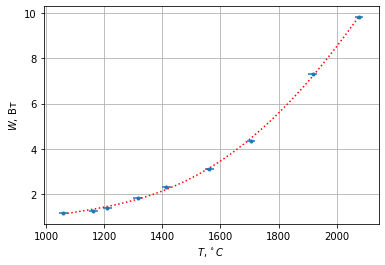

In [229]:
def interp(x, y):
    return interp1d(x, y, kind='cubic')
T = T - 273

mipt.plot(T, W, func=None, marker_size=6, exclude=[], linestyle='dashed', xerr=15)

z = np.polyfit(T, W, 4)
p = np.poly1d(z)
t = np.linspace(T.min(), T.max(), 100)
plt.plot(t, p(t), ms=10, linestyle=':', color="red")


plt.ylabel(r"$W$, Вт")
plt.xlabel(r"$T, ^\circ C$")
plt.grid(True)
# plt.legend()
plt.savefig('gen/fig-wt.pdf')

T = T + 273



In [230]:

export = pd.concat([
    data['Tp'],
    data['I'],
    data['V'],
    W.rename('W'),  
], axis=1)


fmt = {
    'Tp' : [r'$T, ^oC$', '{:.1f}', 0],
    'I' : [r'$I$, А', '{:.2f}', 0],
    'V' : [r'$V$, В', '{:.2f}', 0],
    'W' : [r'$W$, Вт', '{:.2f}', 0],
}

tab = mipt.table(export, fmt)
tab.to_latex('gen/tab-sb.tex')
tab.rename().data

,"$T, ^oC$","$I$, А","$V$, В","$W$, Вт"
0,963.0,0.563,2.115,1.190745
1,1102.0,0.590,2.389,1.409510
2,1057.0,0.571,2.194,1.252774
3,1198.0,0.638,2.881,1.838078
4,1288.0,0.686,3.402,2.333772
5,1424.0,0.752,4.166,3.132832
6,1556.0,0.837,5.218,4.367466
7,1750.0,0.992,7.357,7.298144
8,1897.0,1.098,8.950,9.827100


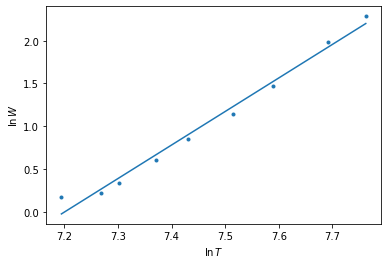

In [231]:
x, y, equ = mipt.plot(np.log(T), np.log(W), exclude=[], yerr = 0)

mnk = mipt.mnk(x, y)
mnk.to_latex('gen/tab-mnk.tex')

plt.ylabel(r"$\lnW$")
plt.xlabel(r"$\lnT$")
plt.savefig('gen/fig-linwt.pdf')

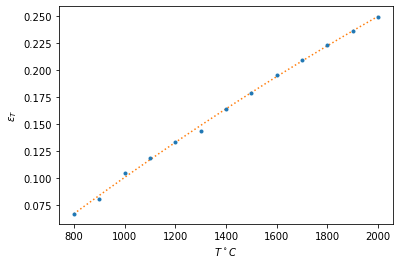

In [232]:
data_eps = mipt.read_excel('data/5.8.1-raw.xlsx', usecols=(5,6), header=(0)).dropna()

x, y, equ = mipt.plot(data_eps['Teps'], data_eps['Eps'], exclude=[], func=None)

z = np.polyfit(data_eps['Teps'], data_eps['Eps'], 2)
epsilon = np.poly1d(z)
t = np.linspace(data_eps['Teps'].min(), data_eps['Teps'].max(), 100)
plt.plot(t, epsilon(t), ms=10, linestyle=':')

plt.xlabel(r"$T ^\circ C$")
plt.ylabel(r"$\varepsilon_T$")
plt.savefig('gen/fig-epsilon.pdf')

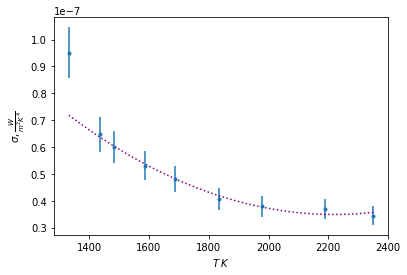

In [233]:
S = 0.36e-4
sigmas = W / (epsilon(T - 273) * T**4 * S)
sigmas

def interp(x, y):
    return interp1d(x, y, kind='cubic', bounds_error=True)

x, y, equ = mipt.plot(T, sigmas, exclude=[], func=None, linestyle='--', yerr=sigmas*0.10)


z = np.polyfit(T[1:], sigmas[1:], 2)
ff = np.poly1d(z)
t = np.linspace(T.min(), T.max(), 100)

plt.plot(t, ff(t), ms=10, linestyle=':', c ='purple')

plt.xlabel(r"$T \;K$")
plt.ylabel(r"$\sigma, \frac{W}{m^2 K^4}$")
plt.savefig('gen/fig-sigma.pdf')

In [234]:
from scipy.interpolate import interp1d
n = np.arange(1, 11, 1)

# x = data['u'][3] * 10 * np.sin(n * consts.pi * setup.tau_impulse * 1e-6/(setup.T_impulse*1e-3)) / (n * consts.pi)

def interp(x, y):
    return interp1d(x, y, kind='cubic')

y = 10 * np.sin(n * consts.pi * setup.tau_impulse * 1e-6/(setup.T_impulse*1e-3)) / (n * consts.pi)
#mipt.plot(n, data['u'], func=None, yerr=setup.v_error)
plt.bar(n, data['u'] / data['u'][0], width = 0.3)
mipt.plot(n, y, func=interp, marker_size=0, linestyle='dashed')

plt.xlabel(r"$\nu_n$, кГц")
plt.ylabel(r"$a_n$")
plt.grid(True)
# plt.legend()
plt.savefig('gen/fig-a9.pdf')




KeyError: 'u'

#### A11 Постройте график зависимости Δ𝜈(1/𝜏). Проведите наилучшую прямую и по её наклону убедитесь в справедливости соотношения неопределённостей для длительности импульса и ширины спектра. Оцените погрешность данного опыта

In [ ]:
dv = data['dv']
tau = data['t']

x, y, equ = mipt.plot(1/tau, dv, yerr = setup.nu_error)
mnk = mipt.mnk(x,y)
mnk.to_latex('gen/tab-a11-mnk.tex')

plt.xlabel(r"$1/\tau$, 1/мс")
plt.ylabel(r"$\nu$, кГц")
plt.grid(True)
# plt.legend()
plt.savefig('gen/fig-a11.pdf')


fmt = {
    'dv' : [r'$\Delta\nu$, кГц', '{:.1f}', 0],
    't' :  [r'$\tau$, мс', '{:.0f}', 0],
    '1/tau' :  [r'$\frac{1}{\tau}$, 1/мс', '{:.4f}', 0],
}

dat = pd.concat([dv, tau, (1/tau).rename('1/tau')],axis=1)
tab = mipt.table(dat, fmt)
tab.to_latex('gen/tab-a11.tex')


#### В21 Постройте график зависимости 𝑎бок/𝑎осн от 𝑚. Проведите наилучшую прямую и сравните результат теоретическим. Оцените погрешность данного опыта.


,$\overline{x}$,$\sigma_x^2$,$\overline{y}$,$\sigma_y^2$,$r_{xy}$,$a\cdot10^3$,$\Delta a \cdot10^3$,$b$,$\Delta b$
0,55.0,825.0,0.216197,0.013571,3.342053,0.004051,0.00007,-0.006607,0.00433


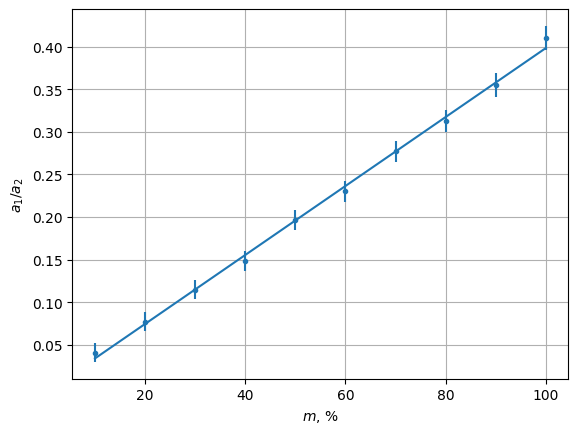

In [14]:
dat = dat = pd.concat([
    data['m'], 
    data['ao'],  
    data['ab'],
    (data['ab']/data['ao']).rename('bo'),
],axis=1)

x, y, equ = mipt.plot(dat['m'], dat['bo'], yerr = 1.5 * dat['bo'] * setup.v_error / dat['ab'])

mnk_fmt = {
    '<x>':    ['$\overline{x}$', '{:.2e}'],
    'sx':     ['$\sigma_x^2$',   '{:.2e}'],
    '<y>':    ['$\overline{y}$', '{:.2e}'],
    'sy':     ['$\sigma_y^2$',   '{:.2e}'],
    'rxy':    ['$r_{xy}$',       '{:.2e}'],
    'a':      ['$a\cdot10^3$', '{:.2f}', 3],
    'da':     ['$\Delta a \cdot10^3$', '{:.2f}', 3],
    'b':      ['$b$',            '{:.2e}'],
    'db':     ['$\Delta b$',     '{:.2e}'],
}


mnk = mipt.mnk(x,y,fmt=mnk_fmt)
mnk.to_latex('gen/tab-v21-mnk.tex')

plt.xlabel(r"$m$, %")
plt.ylabel(r"$a_1/a_2$")
plt.grid(True)
# plt.legend()
plt.savefig('gen/fig-v21.pdf')

fmt = {
    'm'  : [r'$m$, \%', '{:.0f}', 0],
    'ao' : [r'$a_{\text{осн}}$, мВ', '{:.1f}', 0],
    'ab' : [r'$a_{\text{бок}}$, мВ', '{:.1f}', 0],
    'bo' : [r'$\frac{a_{\text{бок}}}{a_{\text{осн}}}$', '{:.4f}', 0],
}

tab = mipt.table(dat, fmt)
tab.to_latex('gen/tab-v21.tex')
mnk.rename().data

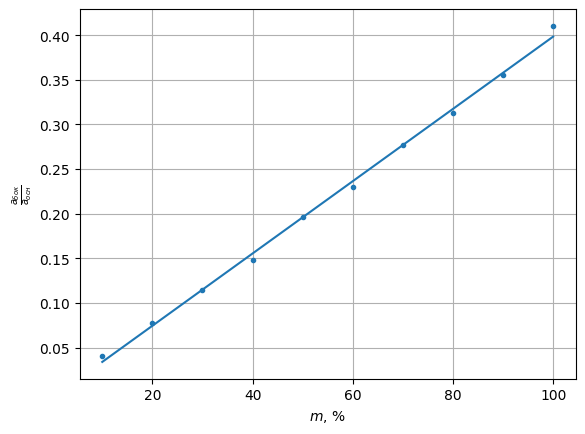

In [15]:
x, y, equ = mipt.plot(dat['m'], dat['bo'])
mnk = mipt.mnk(x,y)
mnk.to_latex('gen/tab-v21-mnk.tex')

plt.xlabel(r"$m$, %")
plt.ylabel(r"$\frac{a_{бок}}{a_{осн}}$")
plt.grid(True)
# plt.legend()
plt.savefig('gen/fig-v21.pdf')


fmt = {
    'm'  : [r'$m$, %', '{:.0f}', 0],
    'ao' : [r'$\tau$, мВ', '{:.1f}', 0],
    'ab' : [r'$\frac{1}{\tau}$, мВ', '{:.1f}', 0],
    'bo' : [r'$\frac{a_{\text{бок}}}{a_{\text{осн}}}$', '{:.4f}', 0],
}

tab = mipt.table(dat, fmt)
tab.to_latex('gen/tab-v21.tex')